In [1]:
from functools import partial
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# 1. Loading the data

In [2]:
images_dir = 'satellite-images-of-water-bodies/Water Bodies Dataset/Images'
masks_dir = 'satellite-images-of-water-bodies/Water Bodies Dataset/Masks'

dirname, _, filenames = next(os.walk(images_dir))

In [3]:
@tf.function
def load_img_with_mask(image_path, images_dir: str = 'Images', masks_dir: str = 'Masks',images_extension: str = 'jpg', masks_extension: str = 'jpg') -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=1, expand_animations = False)
    return (image, mask)

# 2. Exploratory data analysis

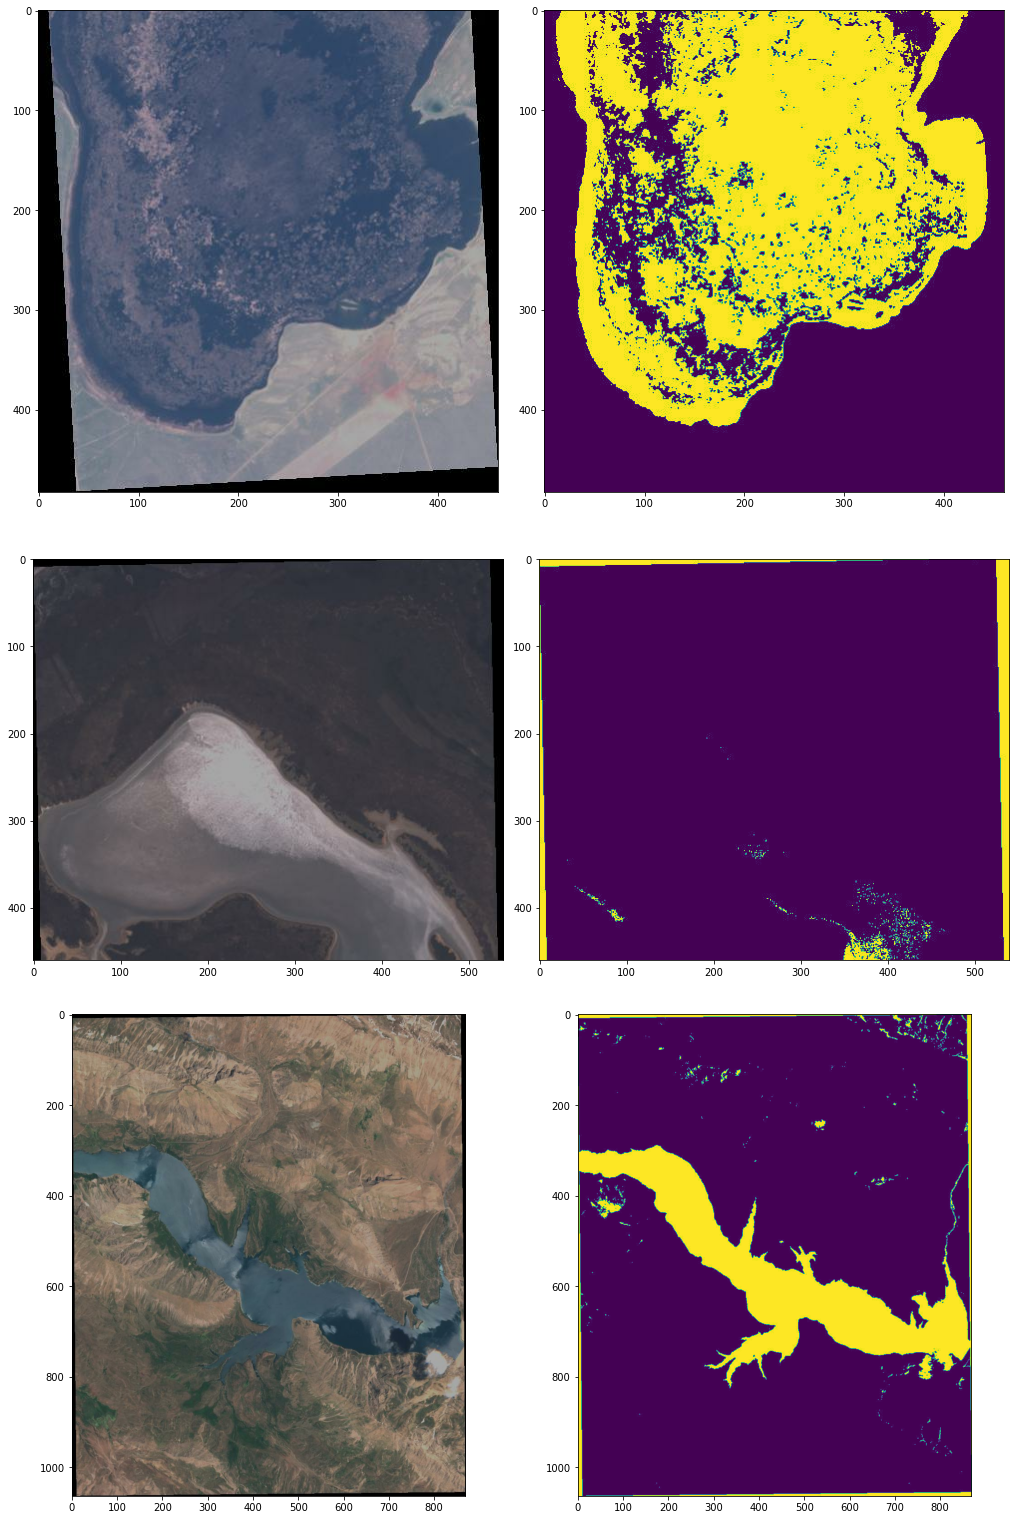

In [4]:
%matplotlib inline
n_examples = 3
examples = [load_img_with_mask(os.path.join(images_dir, filenames[i])) for i in range(n_examples)]

fig, axs = plt.subplots(n_examples, 2, figsize=(14, n_examples*7), constrained_layout=True)
for ax, (image, mask) in zip(axs, examples):
    ax[0].imshow(image)
    ax[1].imshow(mask)

Some images seem to be rotated, it seems worth exploring if the original pictures are in the dataset. If that's the case then testing would be probably spoiled. Additionally in some of these images parts padded during this rotation are marked as water bodies and in some they are not. It may be a good idea to transform the images to get rid of this contradicting ground truths.

''

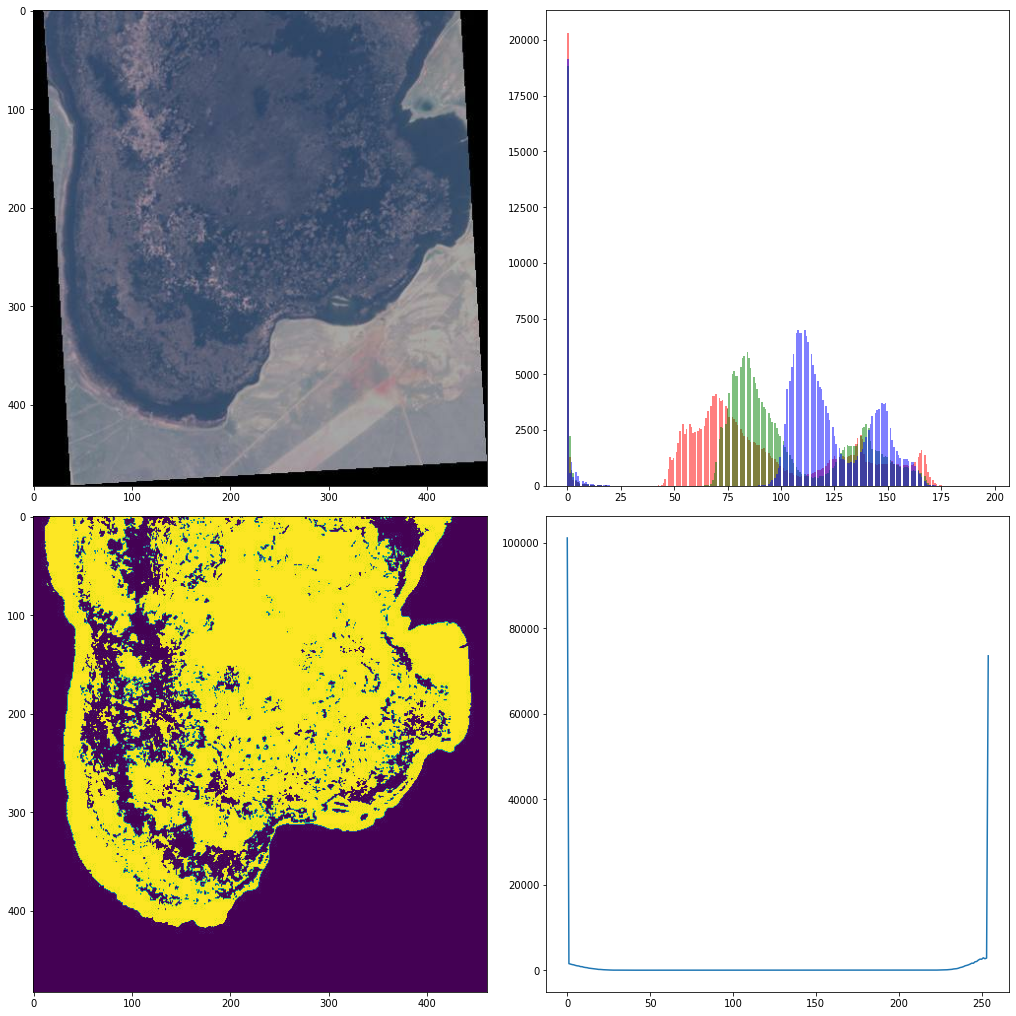

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14), constrained_layout=True)
example_image, example_mask = examples[0]
example_image = np.array(example_image)
example_mask = np.squeeze(example_mask)
axs[0][0].imshow(example_image)
axs[0][1].hist(example_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)

axs[1][0].imshow(example_mask)
histogram, bin_edges = np.histogram(example_mask, bins=256)
axs[1][1].plot(bin_edges[0:-1], histogram)
;

* For the main images there is a lot of values around 0, probably mainly because of the rotation. Values are centered around the middle, it may be a good idea to improve the contrast, maybe using histsogram equalization.
* Mask were stored in jpeg format, so there are no 2 discrete values, we should separate them using some threshold in the middle

# 3. Preprocessing the data

We will use tf.data.Dataset as it's quite easy to fetch the data and apply transformations utilizing optimized tf functions and prefetching.
There are a couple of transformation functions necessary before training our model:
* resize_images: some images wouldn't fit in the memory due to enormous size differences, with some of them having over 3000 in height or width. Only training images over some size threshold are rescaled.
*  convert_masks: splitting masks into 2 discrete values after they were encoded in jpeg
*  scale_values: Dividing images (not masks) to the range [0, 1]  makes the model converge faster
*  pad_images: Due to the specificity of the the used neural net: additional connections between nonconsecutive layers and the same size of input and output image the image sizes should be divisible by the number of downsamplings (taking into consideration the strides). Additionally as we accept arbitrary image sizes we shouldn't just pad to some predetermined values

In [6]:
@tf.function
def resize_images(images, masks, max_image_size=1500):
    shape = tf.shape(images)
    scale = (tf.reduce_max(shape) // max_image_size) + 1
    target_height, target_width = shape[-3] // scale, shape[-2] // scale
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    if scale != 1:
        images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (images, masks)

@tf.function
def scale_values(images, masks, mask_split_threshold = 128):
    images = tf.math.divide(images, 255)
    masks = tf.where(masks > mask_split_threshold, 1, 0)
    return (images, masks)

@tf.function
def pad_images(images, masks, pad_mul=16, offset=0):
    shape = tf.shape(images)
    height, width = shape[-3], shape[-2]
    target_height = height + tf.math.floormod(tf.math.negative(height), pad_mul)
    target_width = width + tf.math.floormod(tf.math.negative(width), pad_mul)
    images = tf.image.pad_to_bounding_box(images, offset, offset, target_height, target_width)
    masks = tf.cast(tf.image.pad_to_bounding_box(masks, offset, offset, target_height, target_width), tf.uint8)
    return (images, masks)

In [7]:
batch_size = 32
test_set_size = 300
validation_set_size = 250

dataset = tf.data.Dataset.list_files(images_dir + '/*.jpg', seed=42)

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)
test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.map(scale_values)
test_dataset = test_dataset.shuffle(20)
test_dataset = test_dataset.map(lambda img, mask: resize_images(img, mask, max_image_size=2500))
test_dataset = test_dataset.map(pad_images)
test_dataset = test_dataset.batch(1).prefetch(5)


validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.map(scale_values)
validation_dataset = validation_dataset.shuffle(20)
validation_dataset = validation_dataset.map(resize_images)
validation_dataset = validation_dataset.map(pad_images)
validation_dataset = validation_dataset.batch(1).prefetch(5)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.map(scale_values)
train_dataset = train_dataset.shuffle(20)
train_dataset = train_dataset.map(resize_images)
train_dataset = train_dataset.map(pad_images)
train_dataset = train_dataset.batch(1).prefetch(5)


# 4. Creating the model

We decided to try training U-net model as it is performing very well in image segmentation task. My implementation has a lower number of channels due to memory restrictions. It also may be simple enough for binary classification.
Here is the image used in the original paper done by Olaf Ronneberger, Philipp Fischer and Thomas Brox:


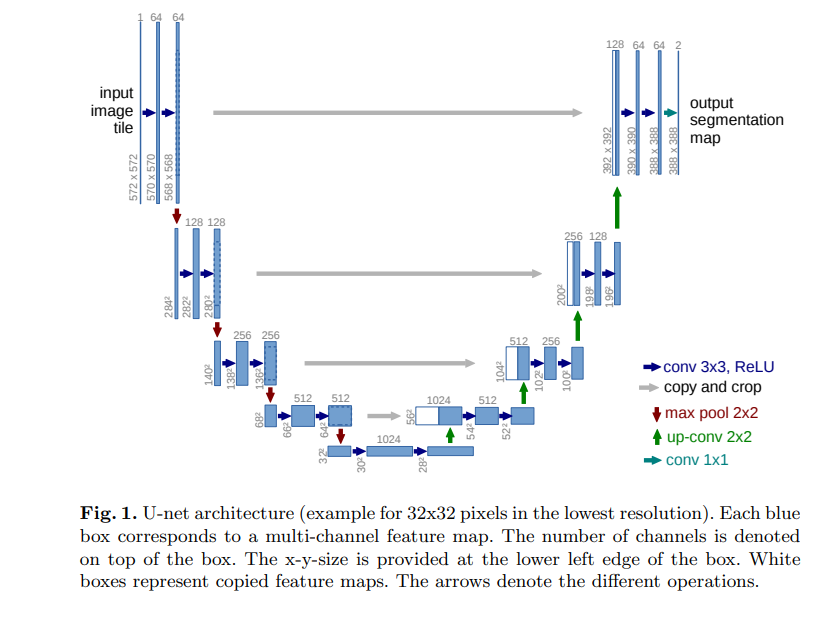

In [8]:
def get_unet(hidden_activation='relu', initializer='he_normal', output_activation='sigmoid'):
    PartialConv = partial(keras.layers.Conv2D,
     activation=hidden_activation,
     kernel_initializer=initializer,      
     padding='same')
    
    # Encoder
    model_input = keras.layers.Input(shape=(None, None, 3))
    enc_cov_1 = PartialConv(32, 3)(model_input)
    enc_cov_1 = PartialConv(32, 3)(enc_cov_1)
    enc_pool_1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_1)
    
    enc_cov_2 = PartialConv(64, 3)(enc_pool_1)
    enc_cov_2 = PartialConv(64, 3)(enc_cov_2)
    enc_pool_2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_2)
    
    enc_cov_3 = PartialConv(128, 3)(enc_pool_2)
    enc_cov_3 = PartialConv(128, 3)(enc_cov_3)
    enc_pool_3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_3)
    
    # Center
    center_cov = PartialConv(256, 3)(enc_pool_3)
    center_cov = PartialConv(256, 3)(center_cov)
    
    # Decoder
    upsampling1 = keras.layers.UpSampling2D(size=(2, 2))(center_cov)
    dec_up_conv_1 = PartialConv(128, 2)(upsampling1)
    dec_merged_1 = tf.keras.layers.Concatenate(axis=3)([enc_cov_3, dec_up_conv_1])
    dec_conv_1 = PartialConv(128, 3)(dec_merged_1)
    dec_conv_1 = PartialConv(128, 3)(dec_conv_1)
    
    upsampling2 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_1)
    dec_up_conv_2 = PartialConv(64, 2)(upsampling2)
    dec_merged_2 = tf.keras.layers.Concatenate(axis=3)([enc_cov_2, dec_up_conv_2])
    dec_conv_2 = PartialConv(64, 3)(dec_merged_2)
    dec_conv_2 = PartialConv(64, 3)(dec_conv_2)
    
    upsampling3 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_2)
    dec_up_conv_3 = PartialConv(32, 2)(upsampling3)
    dec_merged_3 = tf.keras.layers.Concatenate(axis=3)([enc_cov_1, dec_up_conv_3])
    dec_conv_3 = PartialConv(32, 3)(dec_merged_3)
    dec_conv_3 =  PartialConv(32, 3)(dec_conv_3)
    
    output = keras.layers.Conv2D(1, 1, activation=output_activation)(dec_conv_3)
    
    return tf.keras.Model(inputs=model_input, outputs=output)

In [9]:
model = get_unet()

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 3 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 80
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping, lr_reduce])

Epoch 1/80
2291/2291 [==============================] - 1339s 580ms/step - loss: 0.6961 - val_loss: 0.4560
Epoch 2/80
2291/2291 [==============================] - 269s 117ms/step - loss: 0.5400 - val_loss: 0.5247
Epoch 3/80
2291/2291 [==============================] - 152s 66ms/step - loss: 0.4840 - val_loss: 0.4649
Epoch 4/80
2291/2291 [==============================] - 141s 61ms/step - loss: 0.4479 - val_loss: 0.3739
Epoch 5/80
2291/2291 [==============================] - 138s 60ms/step - loss: 0.3807 - val_loss: 0.3634
Epoch 6/80
2291/2291 [==============================] - 134s 58ms/step - loss: 0.3707 - val_loss: 0.3511
Epoch 7/80
2291/2291 [==============================] - 131s 57ms/step - loss: 0.3603 - val_loss: 0.3217
Epoch 8/80
2291/2291 [==============================] - 136s 59ms/step - loss: 0.3595 - val_loss: 0.3446
Epoch 9/80
2291/2291 [==============================] - 135s 59ms/step - loss: 0.3384 - val_loss: 0.3299
Epoch 10/80
2291/2291 [=============================

# 5. Testing the model

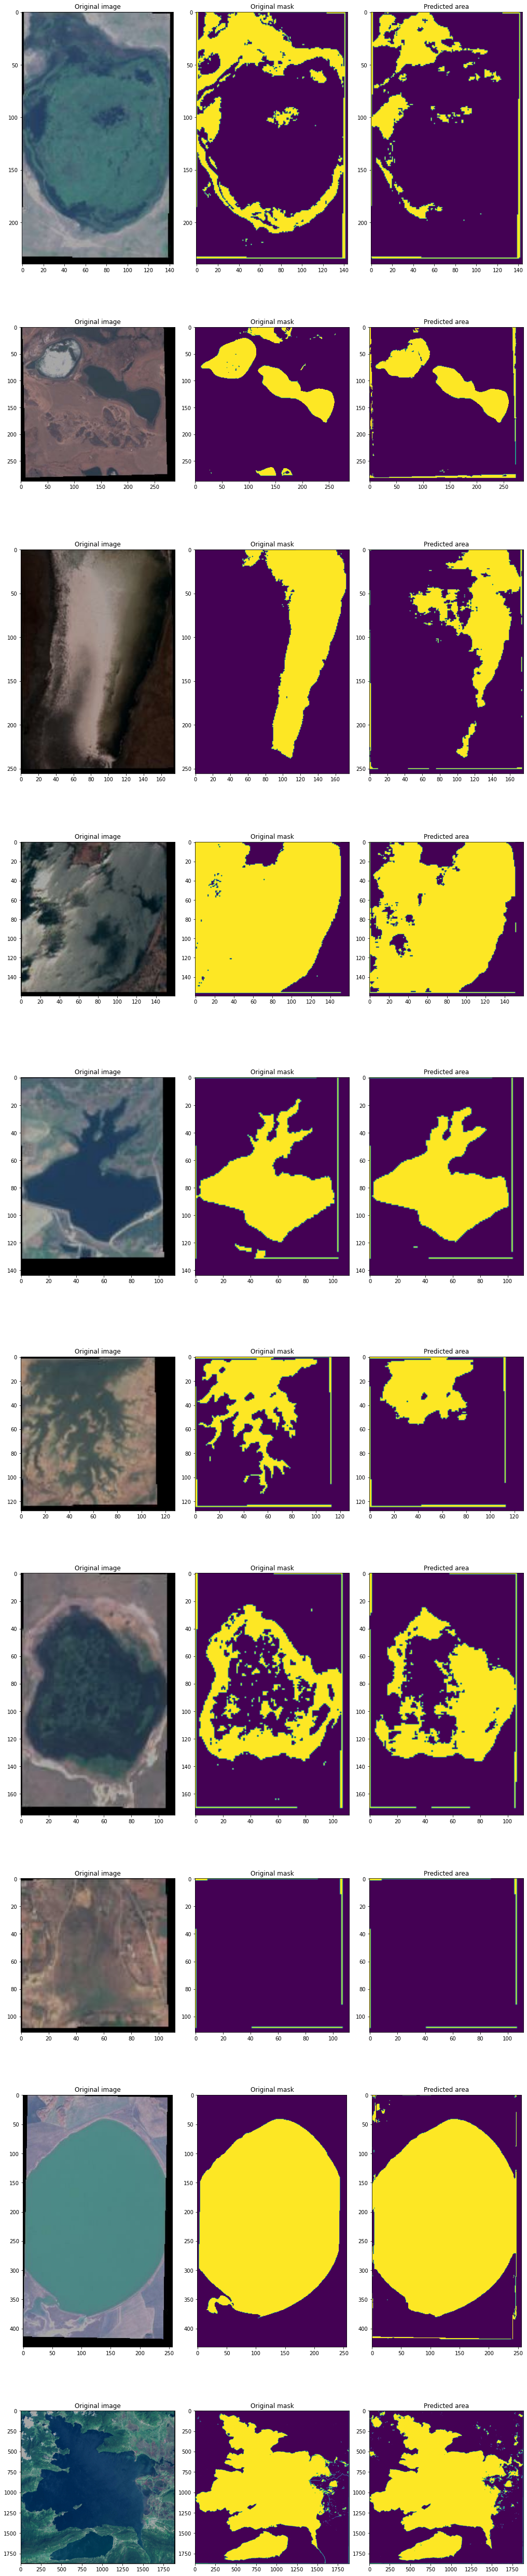

In [12]:
n_examples = 10

fig, axs = plt.subplots(n_examples, 3, figsize=(14, n_examples*7), constrained_layout=True)
for ax, ele in zip(axs, test_dataset.take(n_examples)):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 255, 0)
    ax[0].set_title('Original image')
    ax[0].imshow(image[0])
    ax[1].set_title('Original mask')
    ax[1].imshow(y_true[0])
    ax[2].set_title('Predicted area')
    ax[2].imshow(prediction)

In [13]:
meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
for ele in test_dataset.take(test_set_size):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 1, 0)
    meanIoU.update_state(y_true[0], prediction)
print(meanIoU.result().numpy())

0.7779825
